# Levenberg Marquardt Fitting


## Conventions and best approaches

-   S0 Signal for unbound state
-   S1 Signal for bound state
-   K equilibrium constant (Kd or pKa)
-   order data from unbound to bound (e.g. cl: 0–\>150 mM; pH 9–\>5)

## Initial imports

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import lmfit

## Single Cl titration.

<Axes: xlabel='cl', ylabel='F'>

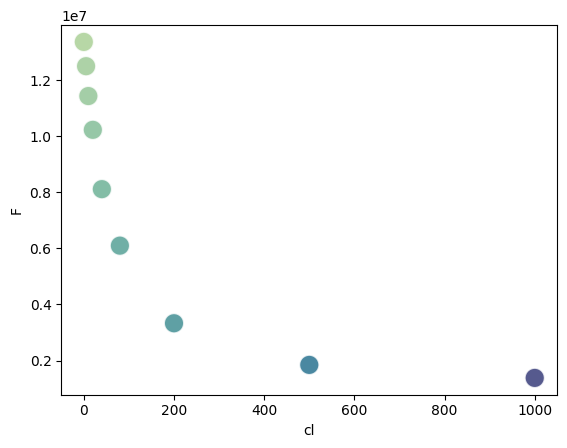

In [2]:
df = pd.read_table("../../tests/data/copyIP.txt")
sb.scatterplot(
    data=df,
    x="cl",
    y="F",
    hue=df.cl * df.F,
    palette="crest",
    s=200,
    alpha=0.8,
    legend=False,
)

### lmfit

[[Variables]]
    S0:  13408867.8 +/- 87130.3362 (0.65%) (init = 1.33579e+07)
    S1:  563537.064 +/- 106411.960 (18.88%) (init = 100)
    Kd:  58.3187767 +/- 2.24671605 (3.85%) (init = 50)
[[Correlations]] (unreported correlations are < 0.100)
    C(S1, Kd) = -0.7123
    C(S0, Kd) = -0.6562
    C(S0, S1) = +0.2747


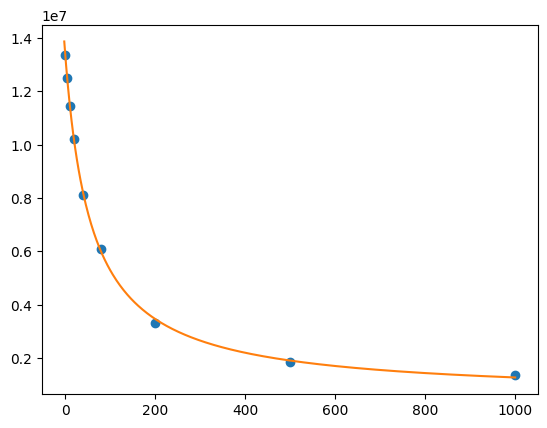

In [3]:
def residual(pars, x, y=None):
    S0 = pars["S0"]
    S1 = pars["S1"]
    Kd = pars["Kd"]
    model = (S0 + S1 * x / Kd) / (1 + x / Kd)
    if y is None:
        return model
    return y - model


params = lmfit.Parameters()
params.add("S0", value=df.F[0])
params.add("S1", value=100)
params.add("Kd", value=50, vary=True)

out = lmfit.minimize(
    residual,
    params,
    args=(
        df.cl,
        df.F,
    ),
)

xdelta = (df.cl.max() - df.cl.min()) / 500
xfit = np.arange(df.cl.min() - xdelta, df.cl.max() + xdelta, xdelta)
yfit = residual(out.params, xfit)
print(lmfit.fit_report(out.params))
plt.plot(df.cl, df.F, "o", xfit, yfit, "-")

In [4]:
def residuals(p):
    S0 = p["S0"]
    S1 = p["S1"]
    Kd = p["Kd"]
    model = (S0 + S1 * df.cl / Kd) / (1 + df.cl / Kd)
    return model - df.F


mini = lmfit.Minimizer(residuals, params)
res = mini.minimize()
ci, tr = lmfit.conf_interval(mini, res, sigmas=[0.68, 0.95], trace=True)
print(lmfit.ci_report(ci, with_offset=False, ndigits=2))
print(lmfit.fit_report(res, show_correl=False, sort_pars=True))

    95.00% 68.00% _BEST_ 68.00% 95.00%
 S0:13197616.3413314946.3513408867.7913503300.3813622729.13
 S1:300911.47447991.63563537.06677869.66819977.61
 Kd:  53.13  55.96  58.32  60.79  64.07
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 9
    # variables        = 3
    chi-square         = 8.3839e+10
    reduced chi-square = 1.3973e+10
    Akaike info crit   = 212.594471
    Bayesian info crit = 213.186145
[[Variables]]
    Kd:  58.3187767 +/- 2.24671605 (3.85%) (init = 50)
    S0:  13408867.8 +/- 87130.3362 (0.65%) (init = 1.33579e+07)
    S1:  563537.064 +/- 106411.960 (18.88%) (init = 100)


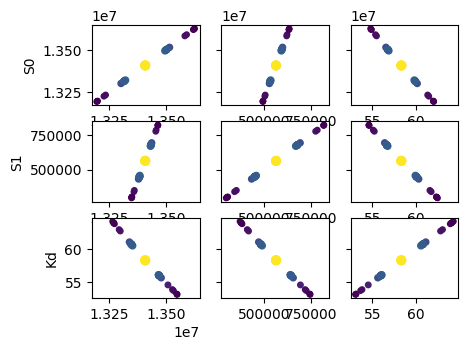

In [5]:
names = res.params.keys()
i = 0
gs = plt.GridSpec(4, 4)
sx = {}
sy = {}
for fixed in names:
    j = 0
    for free in names:
        if j in sx and i in sy:
            ax = plt.subplot(gs[i, j], sharex=sx[j], sharey=sy[i])
        elif i in sy:
            ax = plt.subplot(gs[i, j], sharey=sy[i])
            sx[j] = ax
        elif j in sx:
            ax = plt.subplot(gs[i, j], sharex=sx[j])
            sy[i] = ax
        else:
            ax = plt.subplot(gs[i, j])
            sy[i] = ax
            sx[j] = ax
        if i < 3:
            plt.setp(ax.get_xticklabels(), visible=True)
        else:
            ax.set_xlabel(free)

        if j > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        else:
            ax.set_ylabel(fixed)

        rest = tr[fixed]
        prob = rest["prob"]
        f = prob < 0.96

        x, y = rest[free], rest[fixed]
        ax.scatter(x[f], y[f], c=1 - prob[f], s=25 * (1 - prob[f] + 0.5))
        ax.autoscale(1, 1)
        j += 1
    i += 1

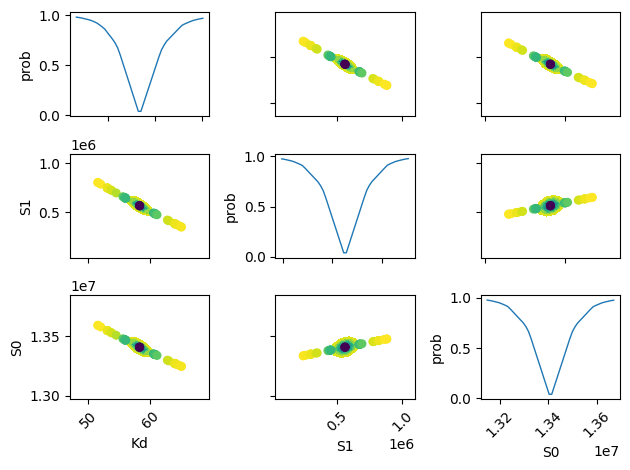

In [6]:
names = list(res.params.keys())

plt.figure()
for i in range(3):
    for j in range(3):
        indx = 9 - j * 3 - i
        ax = plt.subplot(3, 3, indx)
        ax.ticklabel_format(style="sci", scilimits=(-2, 2), axis="y")

        # set-up labels and tick marks
        ax.tick_params(labelleft=False, labelbottom=False)
        if indx in (1, 4, 7):
            plt.ylabel(names[j])
            ax.tick_params(labelleft=True)
        if indx == 1:
            ax.tick_params(labelleft=True)
        if indx in (7, 8, 9):
            plt.xlabel(names[i])
            ax.tick_params(labelbottom=True)
            [label.set_rotation(45) for label in ax.get_xticklabels()]

        if i != j:
            x, y, m = lmfit.conf_interval2d(mini, res, names[i], names[j], 20, 20)
            plt.contourf(x, y, m, np.linspace(0, 1, 10))

            x = tr[names[i]][names[i]]
            y = tr[names[i]][names[j]]
            pr = tr[names[i]]["prob"]
            s = np.argsort(x)
            plt.scatter(x[s], y[s], c=pr[s], s=30, lw=1)

        else:
            x = tr[names[i]][names[i]]
            y = tr[names[i]]["prob"]

            t, s = np.unique(x, True)
            f = scipy.interpolate.interp1d(t, y[s], "slinear")
            xn = np.linspace(x.min(), x.max(), 50)
            plt.plot(xn, f(xn), lw=1)
            plt.ylabel("prob")
            ax.tick_params(labelleft=True)

plt.tight_layout()

[[Variables]]
    S0:  13408867.8 +/- 87130.3362 (0.65%) (init = 1.33579e+07)
    S1:  563537.064 +/- 106411.960 (18.88%) (init = 100)
    Kd:  58.3187767 +/- 2.24671605 (3.85%) (init = 50)
[[Correlations]] (unreported correlations are < 0.250)
    C(S1, Kd) = -0.7123
    C(S0, Kd) = -0.6562
    C(S0, S1) = +0.2747
       95.45%    68.27%    _BEST_    68.27%    95.45%
 S0:-217226.68396-94491.4465413408867.78781+95008.79621+219988.97144
 S1:-270193.31667-116252.05687563537.06418+115024.41863+263650.82002
 Kd:  -5.32812  -2.37783  58.31878  +2.48963  +5.92424


Text(0, 0.5, 'Kd')

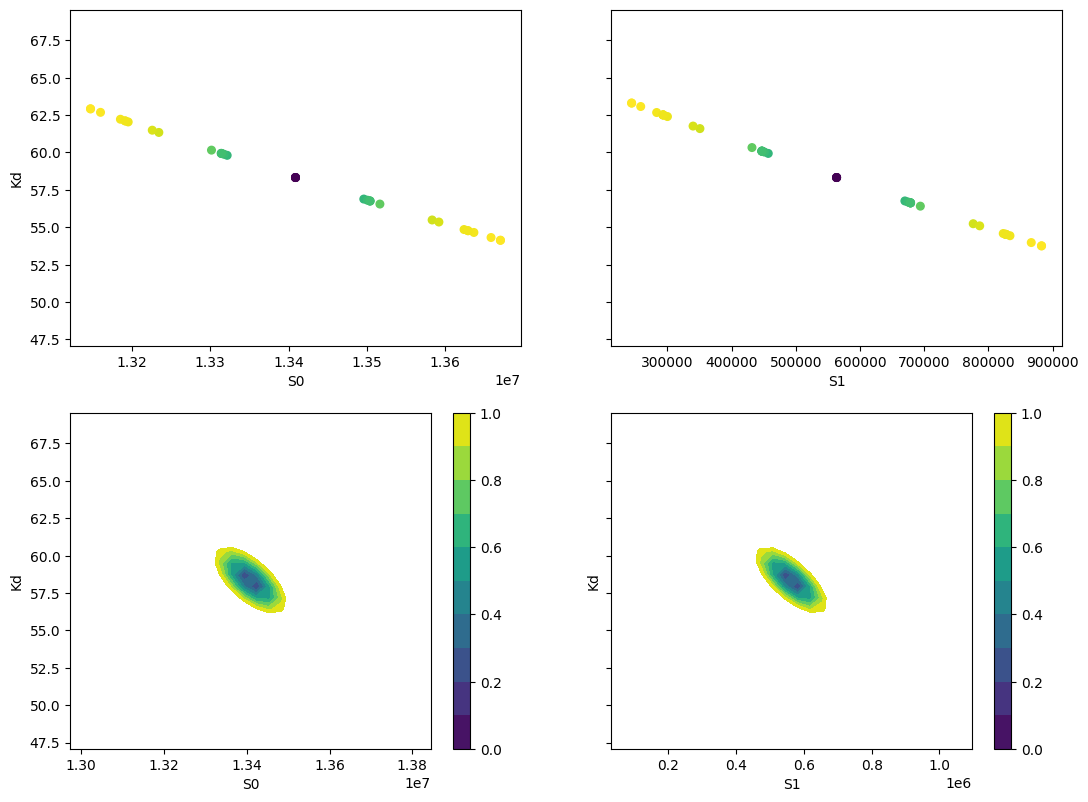

In [7]:
lmfit.report_fit(out.params, min_correl=0.25)

ci, trace = lmfit.conf_interval(mini, res, sigmas=[1, 2], trace=True)
lmfit.printfuncs.report_ci(ci)

fig, axes = plt.subplots(2, 2, figsize=(12.8, 9.6), sharey=True)
cx1, cy1, prob = trace["S0"]["S0"], trace["S0"]["Kd"], trace["S0"]["prob"]
cx2, cy2, prob2 = trace["S1"]["S1"], trace["S1"]["Kd"], trace["S1"]["prob"]

axes[0][0].scatter(cx1, cy1, c=prob, s=30)
axes[0][0].set_xlabel("S0")
axes[0][0].set_ylabel("Kd")

axes[0][1].scatter(cx2, cy2, c=prob2, s=30)
axes[0][1].set_xlabel("S1")

cx, cy, grid = lmfit.conf_interval2d(mini, res, "S0", "Kd", 30, 30)
ctp = axes[1][0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1][0])
axes[1][0].set_xlabel("S0")
axes[1][0].set_ylabel("Kd")

cx, cy, grid = lmfit.conf_interval2d(mini, res, "S1", "Kd", 30, 30)
ctp = axes[1][1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1][1])
axes[1][1].set_xlabel("S1")
axes[1][1].set_ylabel("Kd")

Text(0, 0.5, 'S1')

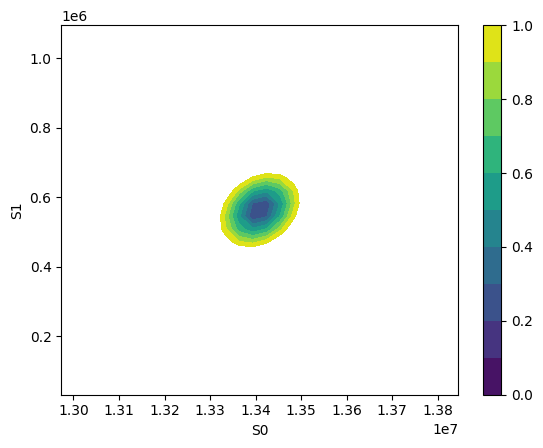

In [8]:
x, y, grid = lmfit.conf_interval2d(mini, res, "S0", "S1", 30, 30)
plt.contourf(x, y, grid, np.linspace(0, 1, 11))
plt.xlabel("S0")
plt.colorbar()
plt.ylabel("S1")

In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import lmfit

## Fit titration with multiple ts


For example data collected with multiple labelblocks in Tecan plate
reader.

“A01”: pH titration with y1 and y2.

In [9]:
df = pd.read_csv("../../tests/data/A01.dat", sep=" ", names=["x", "y1", "y2"])
df = df[::-1].reset_index(drop=True)
df

,x,y1,y2
0,9.030000,29657.0,22885.0
1,8.373333,35200.0,16930.0
2,7.750000,44901.0,9218.0
3,7.073333,53063.0,3758.0
4,6.460000,54202.0,2101.0
5,5.813333,54851.0,1542.0
6,4.996667,51205.0,1358.0


### lmfit of single y1 using analytical Jacobian

It computes the Jacobian of the fz. Mind that the residual (i.e. y - fz)
will be actually minimized.

In [10]:
import sympy

x, S0_1, S1_1, K = sympy.symbols("x S0_1 S1_1 K")
f = (S0_1 + S1_1 * 10 ** (K - x)) / (1 + 10 ** (K - x))
print(sympy.diff(f, S0_1))
print(sympy.diff(f, S1_1))
print(sympy.diff(f, K))

1/(10**(K - x) + 1)
10**(K - x)/(10**(K - x) + 1)
10**(K - x)*S1_1*log(10)/(10**(K - x) + 1) - 10**(K - x)*(10**(K - x)*S1_1 + S0_1)*log(10)/(10**(K - x) + 1)**2


In [11]:
f2 = (S0_1 + S1_1 * x / K) / (1 + x / K)
print(sympy.diff(f2, S0_1))
print(sympy.diff(f2, S1_1))
print(sympy.diff(f2, K))

1/(1 + x/K)
x/(K*(1 + x/K))
-S1_1*x/(K**2*(1 + x/K)) + x*(S0_1 + S1_1*x/K)/(K**2*(1 + x/K)**2)


In [12]:
def residual(pars, x, data):
    S0 = pars["S0"]
    S1 = pars["S1"]
    K = pars["K"]
    # model = (S0 + S1 * x / Kd) / (1 + x / Kd)
    x = np.array(x)
    y = np.array(data)
    model = (S0 + S1 * 10 ** (K - x)) / (1 + 10 ** (K - x))
    if data is None:
        return model
    return y - model


# Try Jacobian
def dfunc(pars, x, data=None):
    S0_1 = pars["S0"]
    S1_1 = pars["S1"]
    K = pars["K"]
    kx = np.array(10 ** (K - x))
    return np.array(
        [
            -1 / (kx + 1),
            -kx / (kx + 1),
            -kx * np.log(10) * (S1_1 / (kx + 1) - (kx * S1_1 + S0_1) / (kx + 1) ** 2),
        ]
    )
    # kx * S1_1 * np.log(10) / (kx + 1) - kx * (kx * S1_1 + S0_1) * np.log(10) / (kx + 1)**2])


params = lmfit.Parameters()
params.add("S0", value=25000, min=0.0)
params.add("S1", value=50000, min=0.0)
params.add("K", value=7, min=2.0, max=12.0)

# out = lmfit.minimize(residual, params, args=(df.x,), kws={'data':df.y1})
# mini = lmfit.Minimizer(residual, params, fcn_args=(df.x, df.y2))
mini = lmfit.Minimizer(residual, params, fcn_args=(df.x,), fcn_kws={"data": df.y1})
# res= mini.minimize()
res = mini.leastsq(Dfun=dfunc, col_deriv=True, ftol=1e-8)

fit = residual(params, df.x, None)
print(lmfit.report_fit(res))

ci = lmfit.conf_interval(mini, res, sigmas=[1, 2, 3])
lmfit.printfuncs.report_ci(ci)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
[[Variables]]
    S0:  26638.8377 +/- 2455.91825 (9.22%) (init = 25000)
    S1:  54043.3592 +/- 979.995977 (1.81%) (init = 50000)
    K:   8.06961091 +/- 0.14940678 (1.85%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(S0, K)  = -0.7750
    C(S1, K)  = -0.4552
    C(S0, S1) = +0.2046
None


/home/dan/workspace/ClopHfit/.hatch/clophfit/lib/python3.10/site-packages/lmfit/confidence.py:317: UserWarning: Bound reached with prob(S0=0.0) = 0.9944737517807747 < max(sigmas)
  warn(errmsg)


       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 S0:      -inf-8376.38956-2895.5618126638.83771+2558.77424+5999.31275+12360.60692
 S1:-6192.81418-2734.30623-1098.2204254043.35921+1113.18257+2829.54298+6725.37841
 K :  -0.98139  -0.40197  -0.15949   8.06961  +0.16276  +0.42591  +1.17272


In [13]:
print(lmfit.ci_report(ci, with_offset=False, ndigits=2))

    99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 S0:   -inf18262.4523743.2826638.8429197.6132638.1538999.44
 S1:47850.5551309.0552945.1454043.3655156.5456872.9060768.74
 K :   7.09   7.67   7.91   8.07   8.23   8.50   9.24


#### emcee

In [14]:
res.params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(1e4))
resMC = lmfit.minimize(
    residual,
    method="emcee",
    steps=300,
    nan_policy="omit",
    is_weighted=False,
    burn=300,
    thin=1,
    params=res.params,
    args=(df.x, df.y1),
    progress=True,
)

100%|██████████| 3000/3000 [00:24<00:00, 125.00it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [50.21877808 54.7962861  49.65739831 62.90350513]


Text(0, 0.5, 'acceptance frac')

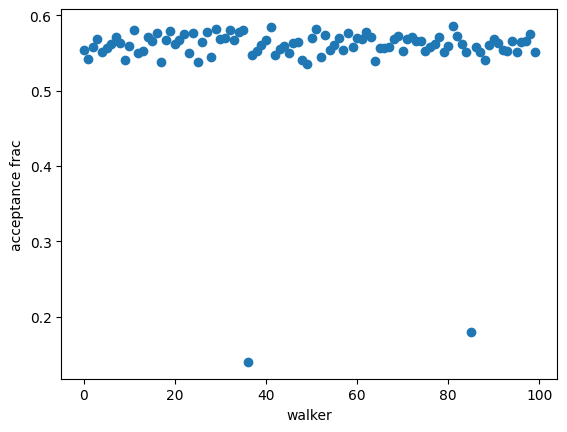

In [15]:
plt.plot(resMC.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance frac")

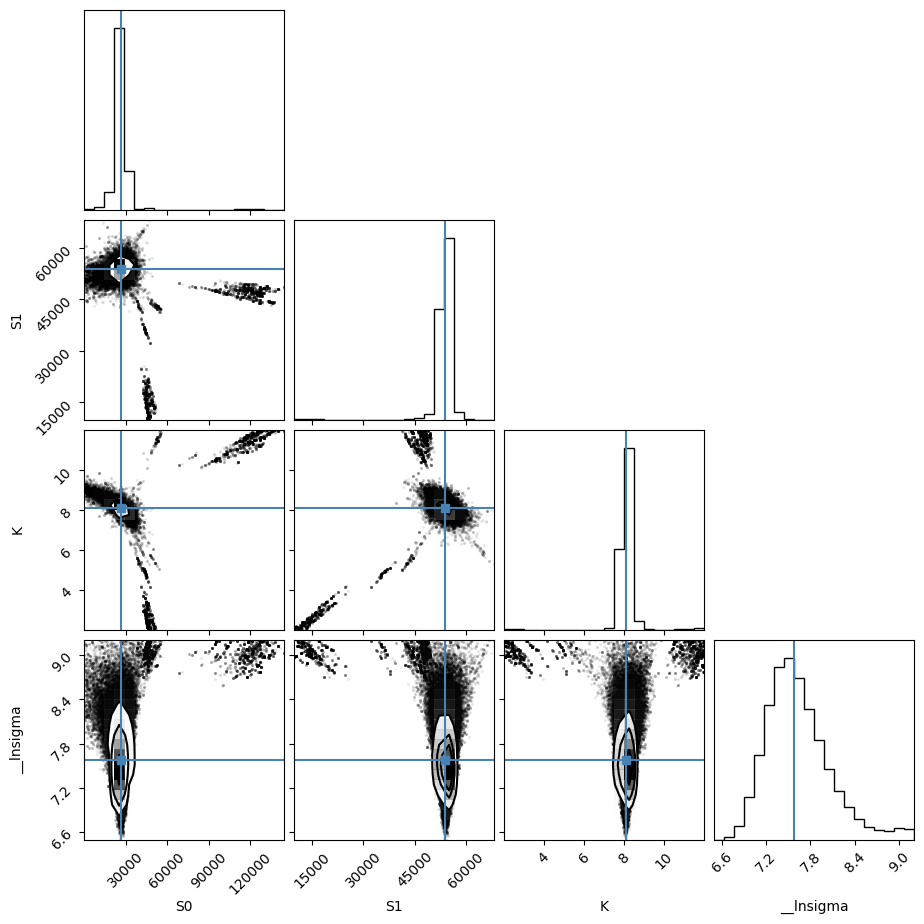

In [16]:
import corner

tr = [v for v in resMC.params.valuesdict().values()]
emcee_plot = corner.corner(
    resMC.flatchain,
    labels=resMC.var_names,
    truths=list(resMC.params.valuesdict().values()),
)
# truths=tr[:-1])

### global

I believe I was using scipy.optimize.

#### using lmfit with np.r\_ trick

In [17]:
# %%timeit #62ms
def residual2(pars, x, data=None):
    K = pars["K"]
    S0_1 = pars["S0_1"]
    S1_1 = pars["S1_1"]
    S0_2 = pars["S0_2"]
    S1_2 = pars["S1_2"]
    model_0 = (S0_1 + S1_1 * 10 ** (K - x[0])) / (1 + 10 ** (K - x[0]))
    model_1 = (S0_2 + S1_2 * 10 ** (K - x[1])) / (1 + 10 ** (K - x[1]))
    if data is None:
        return np.r_[model_0, model_1]
    return np.r_[data[0] - model_0, data[1] - model_1]


params2 = lmfit.Parameters()
params2.add("K", value=7.0, min=2.0, max=12.0)
params2.add("S0_1", value=df.y1[0], min=0.0)
params2.add("S0_2", value=df.y2[0], min=0.0)
params2.add("S1_1", value=df.y1.iloc[-1], min=0.0)
params2.add("S1_2", value=df.y2.iloc[-1], min=0.0)
mini2 = lmfit.Minimizer(
    residual2, params2, fcn_args=([df.x, df.x],), fcn_kws={"data": [df.y1, df.y2]}
)
res2 = mini2.minimize()
print(lmfit.fit_report(res2))

ci2, tr2 = lmfit.conf_interval(mini2, res2, sigmas=[0.68, 0.95], trace=True)
print(lmfit.ci_report(ci2, with_offset=False, ndigits=2))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 14
    # variables        = 5
    chi-square         = 12471473.3
    reduced chi-square = 1385719.25
    Akaike info crit   = 201.798560
    Bayesian info crit = 204.993846
[[Variables]]
    K:     8.07255029 +/- 0.07600777 (0.94%) (init = 7)
    S0_1:  26601.3458 +/- 1425.69913 (5.36%) (init = 29657)
    S0_2:  25084.4189 +/- 1337.07982 (5.33%) (init = 22885)
    S1_1:  54034.5806 +/- 627.642479 (1.16%) (init = 51205)
    S1_2:  1473.57871 +/- 616.944649 (41.87%) (init = 1358)
[[Correlations]] (unreported correlations are < 0.100)
    C(K, S0_1)    = -0.6816
    C(K, S0_2)    = +0.6255
    C(S0_1, S0_2) = -0.4264
    C(K, S1_1)    = -0.3611
    C(K, S1_2)    = +0.3161
    C(S0_2, S1_1) = -0.2259
    C(S0_1, S1_2) = -0.2155
    C(S1_1, S1_2) = -0.1141
      95.00% 68.00% _BEST_ 68.00% 95.00%
 K   :   7.91   7.99   8.07   8.15   8.24
 S0_1:23210.9025078.6226601.3528045.4929623.53
 S

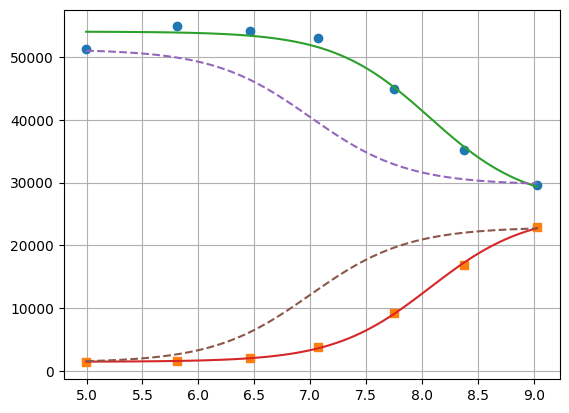

In [18]:
xfit = np.linspace(df.x.min(), df.x.max(), 100)
yfit0 = residual2(params2, [xfit, xfit])
yfit0 = yfit0.reshape(2, 100)
yfit = residual2(res2.params, [xfit, xfit])
yfit = yfit.reshape(2, 100)
plt.plot(
    df.x,
    df.y1,
    "o",
    df.x,
    df.y2,
    "s",
    xfit,
    yfit[0],
    "-",
    xfit,
    yfit[1],
    "-",
    xfit,
    yfit0[0],
    "--",
    xfit,
    yfit0[1],
    "--",
)
plt.grid(True)

#### lmfit constraints aiming for generality

I believe a name convention would be more robust than relying on
OrderedDict Params object.

In [19]:
"S0_1".split("_")[0]

'S0'

In [20]:
def exception_fcn_handler(func):
    def inner_function(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except TypeError:
            print(
                f"{func.__name__} only takes (1D) vector as argument besides lmfit.Parameters."
            )

    return inner_function


@exception_fcn_handler
def titration_pH(params, pH):
    p = {k.split("_")[0]: v for k, v in params.items()}
    return (p["S0"] + p["S1"] * 10 ** (p["K"] - pH)) / (1 + 10 ** (p["K"] - pH))


def residues(params, x, y, fcn):
    return y - fcn(params, x)


p1 = lmfit.Parameters()
p2 = lmfit.Parameters()
p1.add("K_1", value=7.0, min=2.0, max=12.0)
p2.add("K_2", value=7.0, min=2.0, max=12.0)
p1.add("S0_1", value=df.y1.iloc[0], min=0.0)
p2.add("S0_2", value=df.y2.iloc[0], min=0.0)
p1.add("S1_1", value=df.y1.iloc[-1], min=0.0)
p2.add("S1_2", value=df.y2.iloc[-1], min=0.0)

print(
    residues(p1, np.array(df.x), [1.97, 1.8, 1.7, 0.1, 0.1, 0.16, 0.01], titration_pH)
)


def gobjective(params, xl, yl, fcnl):
    nset = len(xl)
    res = []
    for i in range(nset):
        pi = {k: v for k, v in params.valuesdict().items() if k[-1] == f"{i+1}"}
        res = np.r_[res, residues(pi, xl[i], yl[i], fcnl[i])]
        # res = np.r_[res, yl[i] - fcnl[i](parsl[i], x[i])]
    return res


print(gobjective(p1 + p2, [df.x, df.x], [df.y1, df.y2], [titration_pH, titration_pH]))

[-29854.26823732 -30530.32007939 -32908.60749879 -39523.42660007
 -46381.47878947 -49888.5091843  -50993.25866394]
[  -199.23823732   4667.87992061  11990.69250121  13539.47339993
   7820.42121053   4962.3308157     211.73133606    199.04406603
  -5080.73278499 -10416.86307191  -9270.08900503  -4075.72045662
  -1131.04796128   -211.52498939]


Here single.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
[[Variables]]
    K_1:   8.06961042 +/- 0.14940740 (1.85%) (init = 7)
    S0_1:  26638.8440 +/- 2455.92762 (9.22%) (init = 29657)
    S1_1:  54043.3607 +/- 979.995185 (1.81%) (init = 51205)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_1, S0_1)  = -0.7750
    C(K_1, S1_1)  = -0.4552
    C(S0_1, S1_1) = +0.2046
None
         95.45%    68.27%    _BEST_    68.27%    95.45%
 K_1 :  -0.40197  -0.15948   8.06961  +0.16276  +0.42592
 S0_1:-8376.39586-2895.5681226638.84401+2558.76794+5999.32366
 S1_1:-2734.30835-1098.2218354043.36069+1113.18102+2829.55353


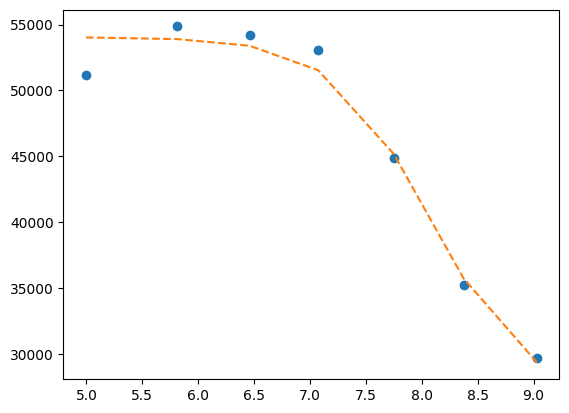

In [21]:
mini = lmfit.Minimizer(
    residues,
    p1,
    fcn_args=(
        df.x,
        df.y1,
        titration_pH,
    ),
)
res = mini.minimize()

fit = titration_pH(res.params, df.x)
print(lmfit.report_fit(res))
plt.plot(df.x, df.y1, "o", df.x, fit, "--")
ci = lmfit.conf_interval(mini, res, sigmas=[1, 2])
lmfit.printfuncs.report_ci(ci)

Now global.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 14
    # variables        = 5
    chi-square         = 12471473.3
    reduced chi-square = 1385719.25
    Akaike info crit   = 201.798560
    Bayesian info crit = 204.993846
[[Variables]]
    K_1:   8.07255029 +/- 0.07600777 (0.94%) (init = 7)
    S0_1:  26601.3458 +/- 1425.69913 (5.36%) (init = 29657)
    S1_1:  54034.5806 +/- 627.642479 (1.16%) (init = 51205)
    K_2:   8.07255029 +/- 0.07600777 (0.94%) == 'K_1'
    S0_2:  25084.4189 +/- 1337.07982 (5.33%) (init = 22885)
    S1_2:  1473.57871 +/- 616.944649 (41.87%) (init = 1358)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_1, S0_1)  = -0.6816
    C(K_1, S0_2)  = +0.6255
    C(S0_1, S0_2) = -0.4264
    C(K_1, S1_1)  = -0.3611
    C(K_1, S1_2)  = +0.3161
    C(S1_1, S0_2) = -0.2259
    C(S0_1, S1_2) = -0.2155
    C(S1_1, S1_2) = -0.1141


ValueError: a, b must bracket a root f(7.844527e+00)=3.045477e-01, f(7.906050e+00)=2.673105e-01 

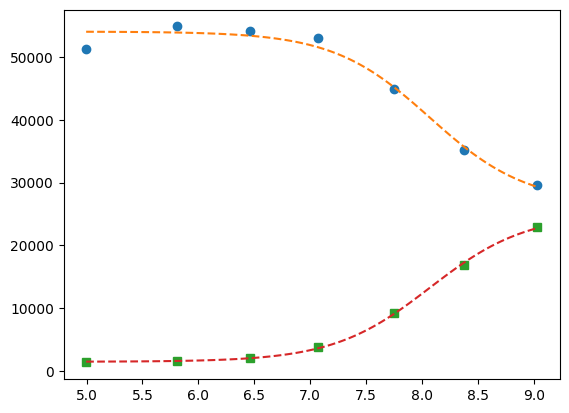

In [22]:
# %%timeit #66ms
pg = p1 + p2
pg["K_2"].expr = "K_1"
# gmini = lmfit.Minimizer(gobjective, pg, fcn_args=([df.x[1:], df.x], [df.y1[1:], df.y2], [titration_pH, titration_pH]))
gmini = lmfit.Minimizer(
    gobjective,
    pg,
    fcn_args=([df.x, df.x], [df.y1, df.y2], [titration_pH, titration_pH]),
)
gres = gmini.minimize()
print(lmfit.fit_report(gres))

pp1 = {k: v for k, v in gres.params.valuesdict().items() if k.split("_")[1] == f"{1}"}
pp2 = {k: v for k, v in gres.params.valuesdict().items() if k.split("_")[1] == f"{2}"}
xfit = np.linspace(df.x.min(), df.x.max(), 100)
yfit1 = titration_pH(pp1, xfit)
yfit2 = titration_pH(pp2, xfit)
plt.plot(df.x, df.y1, "o", xfit, yfit1, "--")
plt.plot(df.x, df.y2, "s", xfit, yfit2, "--")
ci = lmfit.conf_interval(gmini, gres, sigmas=[1, 0.95])
print(lmfit.ci_report(ci, with_offset=False, ndigits=2))

To plot ci for the 5 parameters.

Text(0, 0.5, 'pK1')

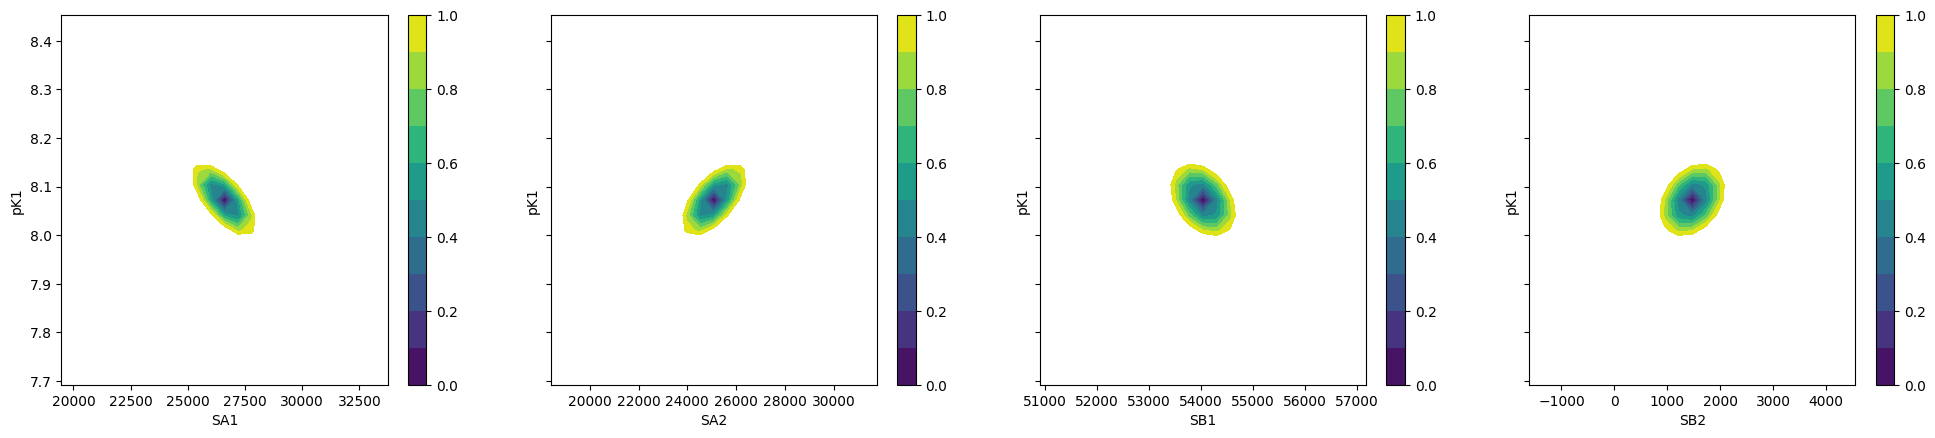

In [16]:
fig, axes = plt.subplots(1, 4, figsize=(24.2, 4.8), sharey=True)
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S0_1", "K_1", 25, 25)
ctp = axes[0].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[0])
axes[0].set_xlabel("SA1")
axes[0].set_ylabel("pK1")
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S0_2", "K_1", 25, 25)
ctp = axes[1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[1])
axes[1].set_xlabel("SA2")
axes[1].set_ylabel("pK1")
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S1_1", "K_1", 25, 25)
ctp = axes[2].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[2])
axes[2].set_xlabel("SB1")
axes[2].set_ylabel("pK1")
cx, cy, grid = lmfit.conf_interval2d(gmini, gres, "S1_2", "K_1", 25, 25)
ctp = axes[3].contourf(cx, cy, grid, np.linspace(0, 1, 11))
fig.colorbar(ctp, ax=axes[3])
axes[3].set_xlabel("SB2")
axes[3].set_ylabel("pK1")

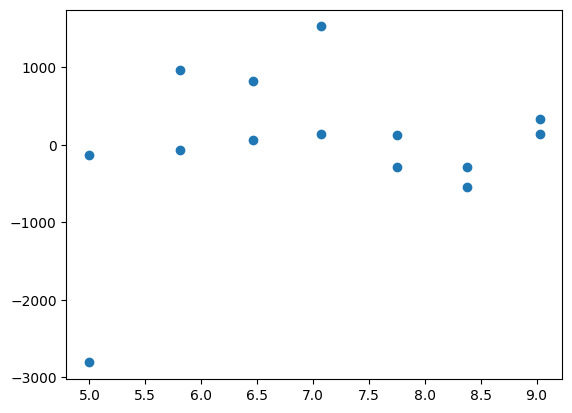

In [17]:
plt.plot(np.r_[df.x, df.x], gres.residual, "o")

##### emcee

In [18]:
gmini.params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(2))
gresMC = lmfit.minimize(
    gobjective,
    method="emcee",
    steps=1800,  # workers=8,
    nan_policy="omit",
    burn=30,
    is_weighted=False,  # thin=20,
    params=gmini.params,
    args=([df.x, df.x], [df.y1, df.y2], [titration_pH, titration_pH]),
    progress=True,
)

100%|██████████| 1800/1800 [03:39<00:00,  8.21it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 36;
tau: [ 51.56604218  68.21162389  78.58448607  19.85718351  66.43015686
 124.07081237]


This next block comes from:
<https://lmfit.github.io/lmfit-py/examples/example_emcee_Model_interface.html?highlight=emcee>

In [19]:
emcee_kws = dict(
    steps=5000,
    burn=500,
    thin=20,
    is_weighted=False,
)
emcee_params = gmini.params.copy()
emcee_params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

mi = lmfit.Minimizer(
    gobjective,
    emcee_params,
    fcn_args=([df.x, df.x], [df.y1, df.y2], [titration_pH, titration_pH]),
)

res_emcee = mi.minimize(method="emcee", steps=500, burn=50, thin=20, is_weighted=False)

100%|██████████| 500/500 [01:06<00:00,  7.56it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [21.23649351 20.94378345 32.01907222 35.72323367 33.09422763 61.62359046]


In [20]:
# result_emcee = model.fit(data=y, x=x, params=emcee_params, method='emcee',
#                          nan_policy='omit', fit_kws=emcee_kws)

lmfit.report_fit(res_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 50000
    # data points      = 14
    # variables        = 6
    chi-square         = 3156766.17
    reduced chi-square = 394595.771
    Akaike info crit   = 184.564019
    Bayesian info crit = 188.398363
[[Variables]]
    K_1:        8.07329906 +/- 0.03058906 (0.38%) (init = 8.07255)
    S0_1:       26593.9620 +/- 419.547413 (1.58%) (init = 26601.35)
    S1_1:       54035.4049 +/- 428.530872 (0.79%) (init = 54034.58)
    K_2:        8.07329906 == 'K_1'
    S0_2:       25170.2434 +/- 1538.16281 (6.11%) (init = 25084.42)
    S1_2:       1497.65804 +/- 214.376806 (14.31%) (init = 1473.579)
    __lnsigma:  0.68745956 +/- 0.14613446 (21.26%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_1, S0_1)       = -0.8474
    C(S1_1, S0_2)      = -0.6959
    C(S0_1, S0_2)      = -0.5111
    C(K_1, S0_2)       = +0.4243
    C(S0_2, S1_2)      = +0.3694
    C(S1_1, S1_2)      = -0.1509
    C(K

Text(0, 0.5, 'acceptance frac')

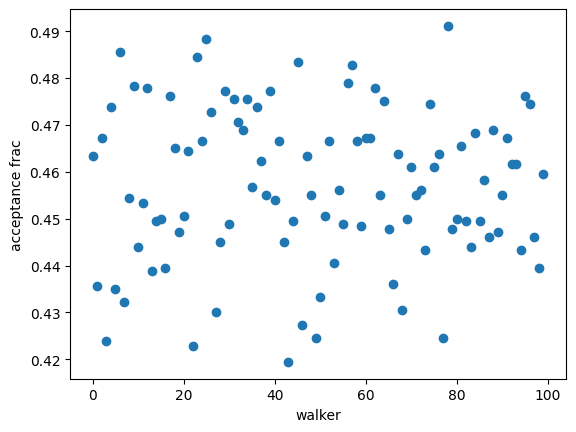

In [21]:
plt.plot(gresMC.acceptance_fraction, "o")
plt.xlabel("walker")
plt.ylabel("acceptance frac")

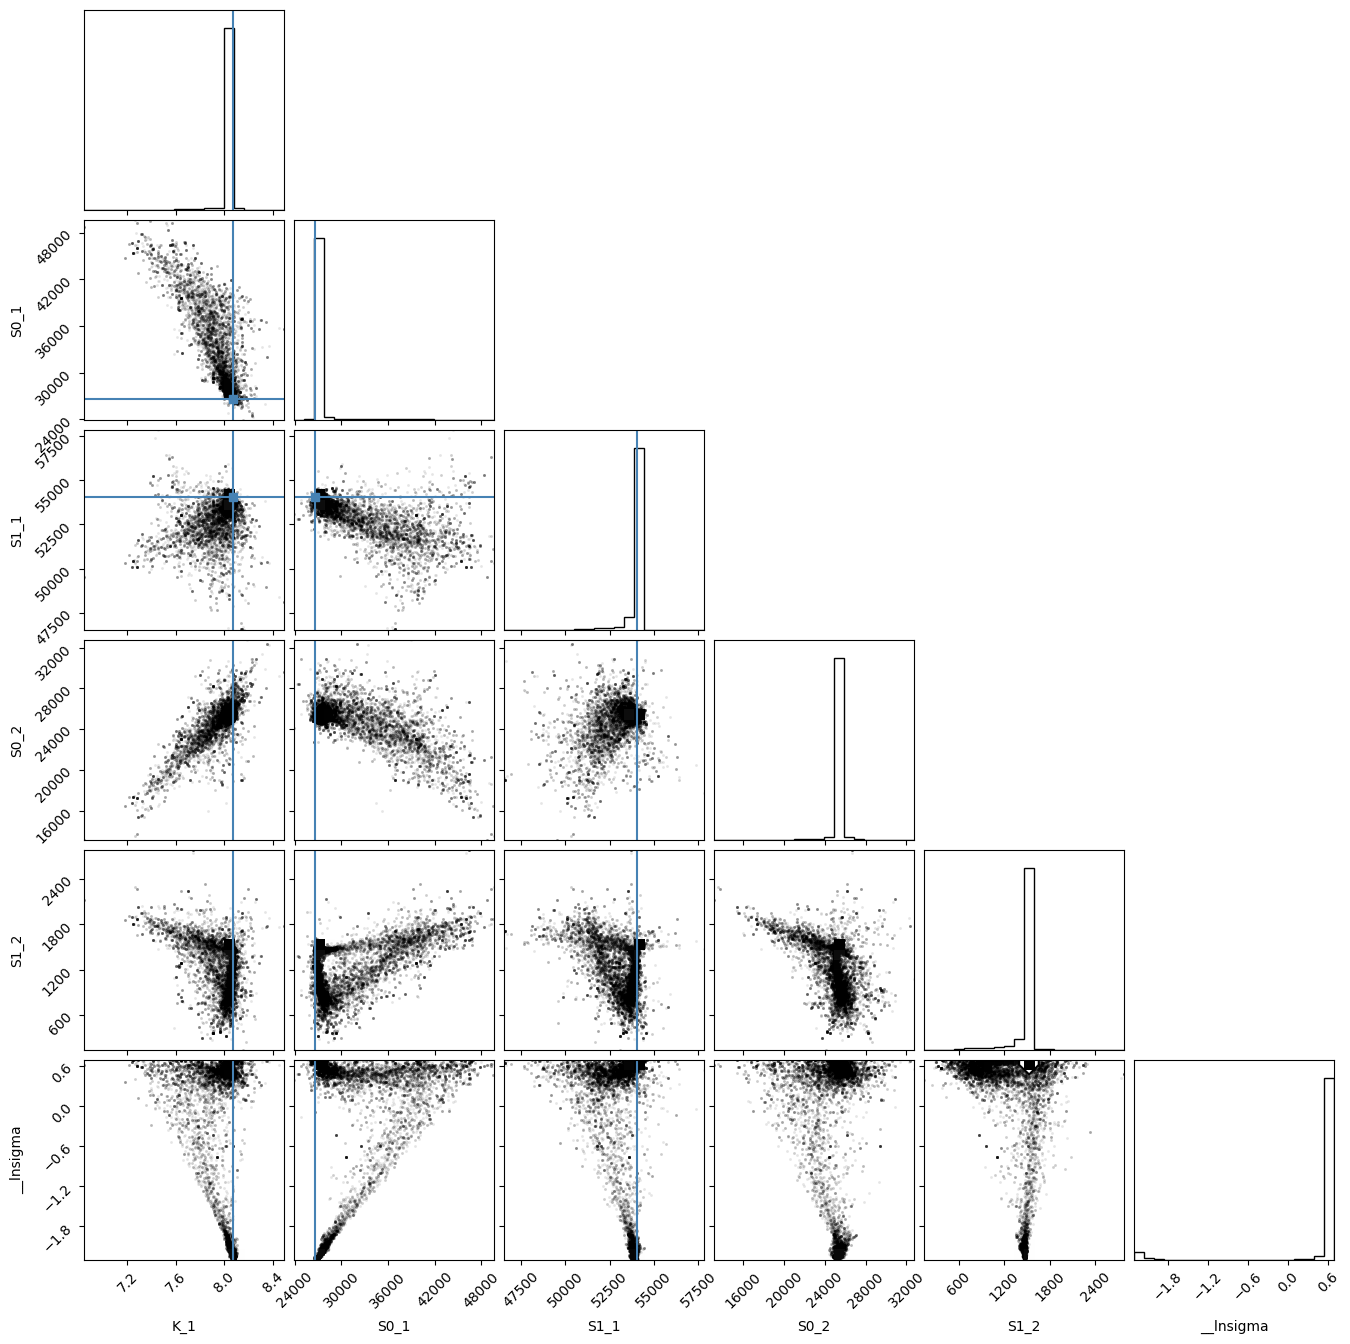

In [22]:
import corner

tr = [v for v in gresMC.params.valuesdict().values()]
emcee_plot = corner.corner(
    gresMC.flatchain,
    labels=gresMC.var_names,
    # truths=list(gresMC.params.valuesdict().values()))
    truths=tr[:-1],
)

In [23]:
lmfit.report_fit(gresMC.params)

[[Variables]]
    K_1:        8.07253052 +/- 1.9642e-04 (0.00%) (init = 8.07255)
    S0_1:       26602.1275 +/- 29.9716350 (0.11%) (init = 26601.35)
    S1_1:       54034.3176 +/- 9.51808189 (0.02%) (init = 54034.58)
    K_2:        8.07253052 == 'K_1'
    S0_2:       25084.4180 +/- 3.34455164 (0.01%) (init = 25084.42)
    S1_2:       1473.40523 +/- 1.67435725 (0.11%) (init = 1473.579)
    __lnsigma:  0.69314685 +/- 2.4150e-04 (0.03%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(K_1, S0_1)       = -0.8681
    C(S0_1, S1_1)      = -0.7863
    C(K_1, S0_2)       = +0.7313
    C(S0_1, S0_2)      = -0.5940
    C(K_1, S1_1)       = +0.5600
    C(S1_1, S0_2)      = +0.3722
    C(S0_2, S1_2)      = -0.3333
    C(S1_1, __lnsigma) = +0.1440
    C(S0_1, __lnsigma) = -0.1322


In [28]:
highest_prob = np.argmax(gresMC.lnprob)
hp_loc = np.unravel_index(highest_prob, gresMC.lnprob.shape)
mle_soln = gresMC.chain[hp_loc]
for i, par in enumerate(pg):
    pg[par].value = mle_soln[i]

print("\nMaximum Likelihood Estimation from emcee       ")
print("-------------------------------------------------")
print("Parameter  MLE Value   Median Value   Uncertainty")
fmt = "  {:5s}  {:11.5f} {:11.5f}   {:11.5f}".format
for name, param in pg.items():
    print(fmt(name, param.value, gresMC.params[name].value, gresMC.params[name].stderr))


Maximum Likelihood Estimation from emcee       
-------------------------------------------------
Parameter  MLE Value   Median Value   Uncertainty
  K_1        8.07259     8.07253       0.00020
  S0_1   26600.69138 26602.12753      29.97163
  S1_1   54034.51176 54034.31756       9.51808


TypeError: unsupported format string passed to NoneType.__format__

In [29]:
print("\nError estimates from emcee:")
print("------------------------------------------------------")
print("Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma")

for name in pg.keys():
    quantiles = np.percentile(
        gresMC.flatchain[name], [2.275, 15.865, 50, 84.135, 97.275]
    )
    median = quantiles[2]
    err_m2 = quantiles[0] - median
    err_m1 = quantiles[1] - median
    err_p1 = quantiles[3] - median
    err_p2 = quantiles[4] - median
    fmt = "  {:5s}   {:8.4f} {:8.4f} {:8.4f} {:8.4f} {:8.4f}".format
    print(fmt(name, err_m2, err_m1, median, err_p1, err_p2))


Error estimates from emcee:
------------------------------------------------------
Parameter  -2sigma  -1sigma   median  +1sigma  +2sigma
  K_1      -0.1398  -0.0002   8.0725   0.0002   0.0023
  S0_1     -5.6441  -2.8962 26602.1275  57.1524 5929.2772
  S1_1    -1397.6932 -17.8504 54034.3176   1.2488   2.5107


KeyError: 'K_2'

#### bootstrap con pandas

In [54]:
%%timeit
for i in range(100):
    tdf = pd.DataFrame([(j, i) for i in range(7) for j in range(2)]).sample(
        14, replace=True, ignore_index=False
    )
    df1 = df[["x", "y1"]].iloc[np.array(tdf[tdf[0] == 0][1])]
    df2 = df[["x", "y2"]].iloc[np.array(tdf[tdf[0] == 1][1])]

206 ms ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
# %%timeit
def idx_sample(npoints):
    tidx = []
    for i in range(npoints):
        tidx.append((np.random.randint(2), np.random.randint(7)))
    idx1 = []
    idx2 = []
    for t in tidx:
        if t[0] == 0:
            idx1.append(t[1])
        elif t[0] == 1:
            idx2.append(t[1])
        else:
            raise Exception("Must never occur")
    return idx1, idx2


for i in range(100):
    idx1, idx2 = idx_sample(14)
    df1 = (
        df[["x", "y1"]]
        .iloc[idx1]
        .sort_values(by="x", ascending=False)
        .reset_index(drop=True)
    )
    df2 = (
        df[["x", "y2"]]
        .iloc[idx2]
        .sort_values(by="x", ascending=False)
        .reset_index(drop=True)
    )

In [56]:
# %%timeit  #5-6 s for nboot=7 now 0.4s
n_points = len(df)
nboot = 199
np.random.seed(5)
best = lmfit.minimize(
    gobjective,
    pg,
    args=([df.x[1:], df.x], [df.y1[1:], df.y2], [titration_pH, titration_pH]),
)
nb = {k: [] for k in best.params.keys()}

for i in range(nboot):
    idx1, idx2 = idx_sample(13)
    df1 = (
        df[["x", "y1"]]
        .iloc[idx1]
        .sort_values(by="x", ascending=False)
        .reset_index(drop=True)
    )
    df2 = (
        df[["x", "y2"]]
        .iloc[idx2]
        .sort_values(by="x", ascending=False)
        .reset_index(drop=True)
    )
    # boot_idxs = np.random.randint(0, n_points, n_points)
    # df2 = df.iloc[boot_idxs]
    # df2=df2.sort_values(by="x", ascending=False).reset_index(drop=True)
    # # df2.reset_index(drop=True, inplace=True)
    # boot_idxs = np.random.randint(0, n_points, n_points)
    # df3 = df.iloc[boot_idxs]
    # # df3.reset_index(drop=True, inplace=True)
    # df3=df3.sort_values(by="x", ascending=False).reset_index(drop=True)
    try:
        out = lmfit.minimize(
            gobjective,
            best.params,
            args=([df1.x, df2.x], [df1.y1, df2.y2], [titration_pH, titration_pH]),
            calc_covar=False,
            method="leastsq",
            nan_policy="omit",
            scale_covar=False,
        )
        for k, v in out.params.items():
            nb[k].append(v.value)
    except:
        print(df1)
        print(df2)

# print(nb)

In [57]:
np.quantile(nb["K_1"], [0.025, 0.5, 0.975])

array([7.97738171, 8.07819767, 8.64993194])

<Axes: xlabel='K_1', ylabel='S1_2'>

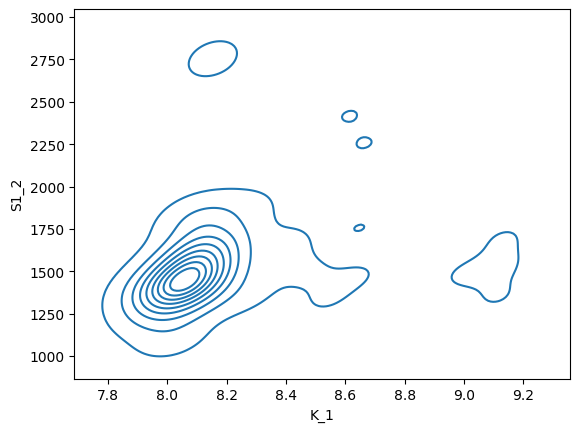

In [58]:
sb.kdeplot(data=nb, x="K_1", y="S1_2")

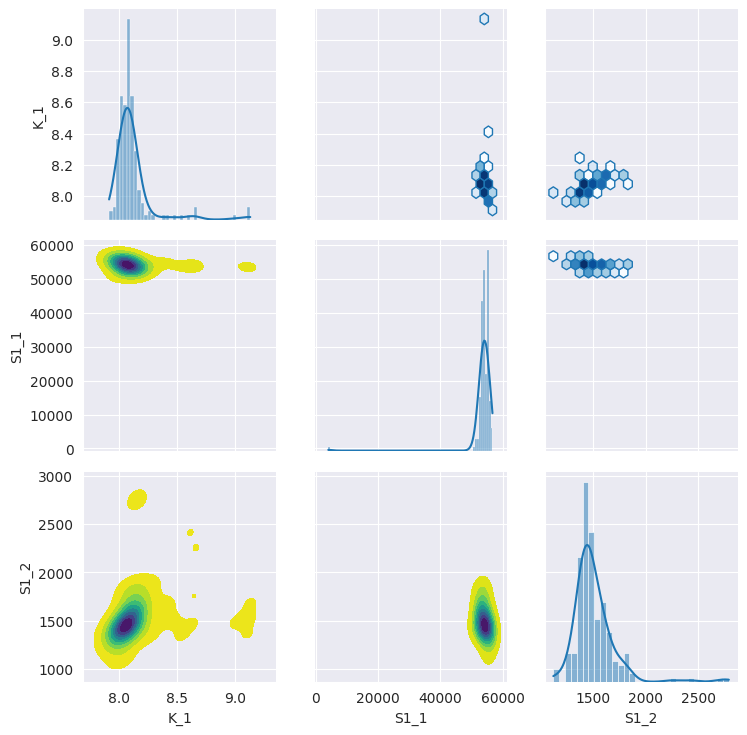

In [59]:
# nb.drop("K_2", axis=1, inplace=True)
with sb.axes_style("darkgrid"):
    g = sb.PairGrid(pd.DataFrame(nb), diag_sharey=False, vars=["K_1", "S1_1", "S1_2"])
    g.map_upper(plt.hexbin, bins="log", gridsize=20, cmap="Blues", mincnt=2)
    g.map_lower(sb.kdeplot, cmap="viridis_r", fill=True)
    g.map_diag(sb.histplot, kde=True)

<Axes: >

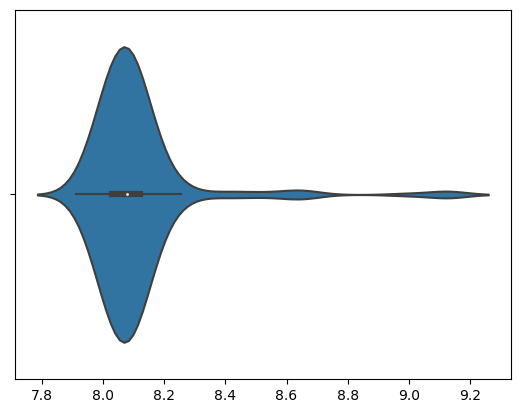

In [60]:
sb.violinplot(data=nb, x="K_1", split=True)

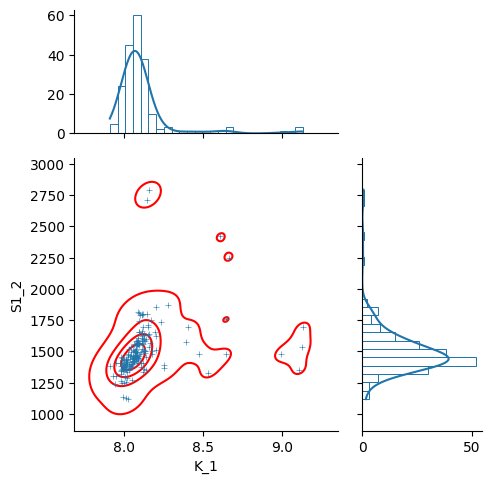

In [61]:
g = sb.jointplot(
    y="S1_2",
    x="K_1",
    data=nb,
    marker="+",
    s=25,
    marginal_kws=dict(bins=25, fill=False, kde=True),
    color="#2075AA",
    marginal_ticks=True,
    height=5,
    ratio=2,
)
g.plot_joint(sb.kdeplot, color="r", zorder=0, levels=5)

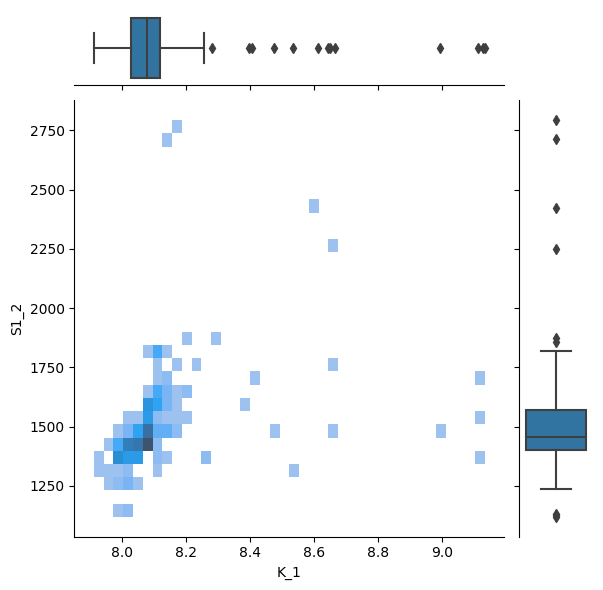

In [62]:
g = sb.JointGrid(data=nb, x="K_1", y="S1_2")
g.plot_joint(sb.histplot)
g.plot_marginals(sb.boxplot)

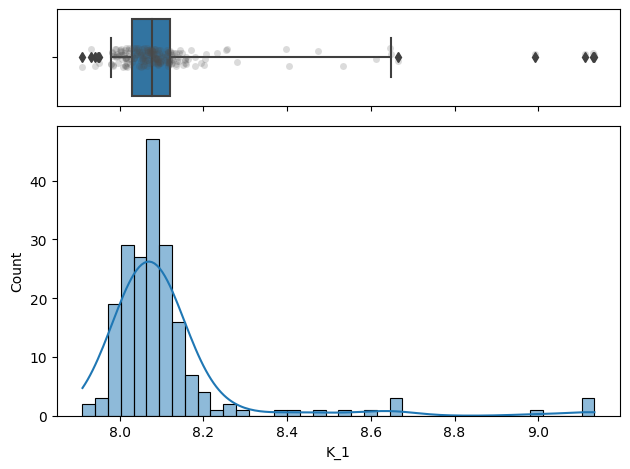

In [63]:
f, (ax_box, ax_hist) = plt.subplots(
    2, sharex=True, gridspec_kw={"height_ratios": (0.25, 0.75)}
)

sb.histplot(data=nb, x="K_1", kde=True, ax=ax_hist)

sb.boxplot(x="K_1", data=nb, whis=[2.5, 97.5], ax=ax_box)
sb.stripplot(x="K_1", data=nb, color=".3", alpha=0.2, ax=ax_box)
ax_box.set(xlabel="")
f.tight_layout()
# ax = sb.violinplot(x="K_1", data=nb, inner=None, color="r")

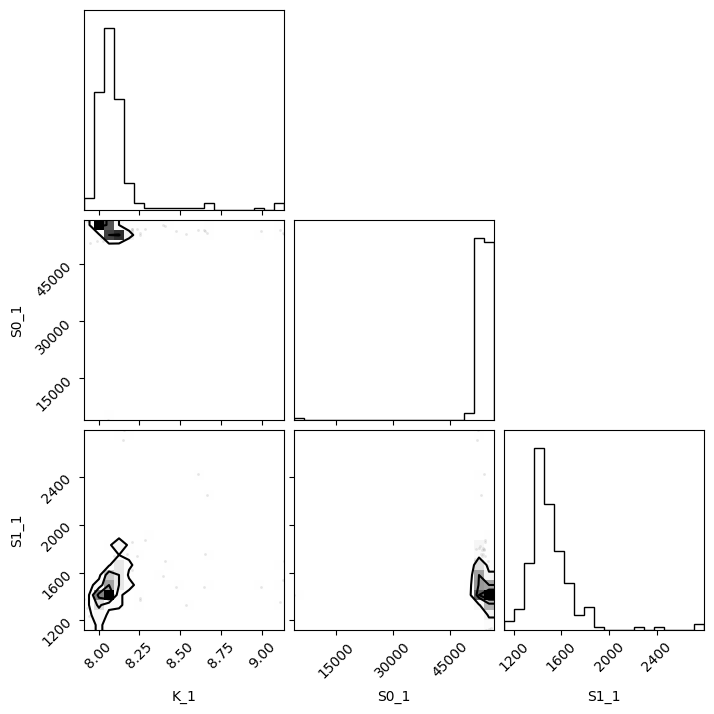

In [64]:
import corner

g = corner.corner(pd.DataFrame(nb)[["K_1", "S1_1", "S1_2"]], labels=list(nb.keys()))

#### lmfit.Model

It took 9 vs 5 ms. It is not possible to do global fitting. In the
documentation it is stressed the need to convert the output of the
residue to be 1D vectors.

In [30]:
mod = lmfit.models.ExpressionModel("(SB + SA * 10**(pK-x)) / (1 + 10**(pK-x))")
result = mod.fit(np.array(df.y1), x=np.array(df.x), pK=7, SB=7e3, SA=10000)
print(result.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
    R-squared          = 0.97973543
[[Variables]]
    SB:  26638.9314 +/- 2456.05773 (9.22%) (init = 7000)
    SA:  54043.3812 +/- 979.984193 (1.81%) (init = 10000)
    pK:  8.06960356 +/- 0.14941163 (1.85%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(SB, pK) = -0.7750
    C(SA, pK) = -0.4552
    C(SB, SA) = +0.2046


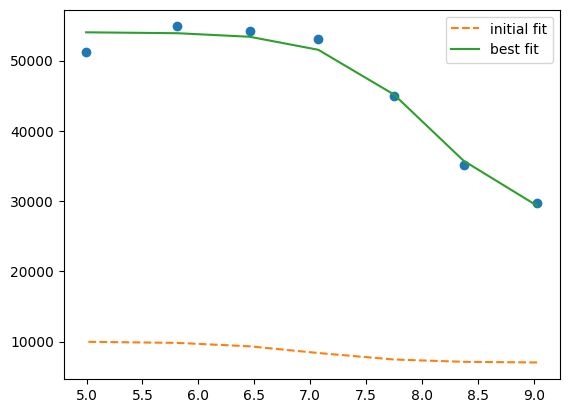

In [31]:
plt.plot(df.x, df.y1, "o")
plt.plot(df.x, result.init_fit, "--", label="initial fit")
plt.plot(df.x, result.best_fit, "-", label="best fit")
plt.legend()

In [32]:
print(result.ci_report())

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 SB:-85235.83517-8376.49744-2895.6555126638.93141+2558.68054+5999.21905+12360.51318
 SA:-6192.83614-2734.32819-1098.2423854043.38116+1113.16062+2829.52103+6725.35644
 pK:  -0.98138  -0.40196  -0.15948   8.06960  +0.16277  +0.42592  +1.50919


which is faster but still I failed to find the way to global fitting.

In [33]:
def tit_pH(x, S0, S1, K):
    return (S0 + S1 * 10 ** (K - x)) / (1 + 10 ** (K - x))


tit_model1 = lmfit.Model(tit_pH, prefix="ds1_")
tit_model2 = lmfit.Model(tit_pH, prefix="ds2_")
print(f"parameter names: {tit_model1.param_names}")
print(f"parameter names: {tit_model2.param_names}")
print(f"independent variables: {tit_model1.independent_vars}")
print(f"independent variables: {tit_model2.independent_vars}")

tit_model1.set_param_hint("K", value=7.0, min=2.0, max=12.0)
tit_model1.set_param_hint("S0", value=df.y1[0], min=0.0)
tit_model1.set_param_hint("S1", value=df.y1.iloc[-1], min=0.0)
tit_model2.set_param_hint("K", value=7.0, min=2.0, max=12.0)
tit_model2.set_param_hint("S0", value=df.y1[0], min=0.0)
tit_model2.set_param_hint("S1", value=df.y1.iloc[-1], min=0.0)
pars1 = tit_model1.make_params()
pars2 = tit_model2.make_params()
# gmodel = tit_model1 + tit_model2
# result = gmodel.fit(df.y1 + df.y2, pars, x=df.x)
res1 = tit_model1.fit(df.y1, pars1, x=df.x)
res2 = tit_model2.fit(df.y2, pars2, x=df.x)
print(res1.fit_report())
print(res2.fit_report())

parameter names: ['ds1_S0', 'ds1_S1', 'ds1_K']
parameter names: ['ds2_S0', 'ds2_S1', 'ds2_K']
independent variables: ['x']
independent variables: ['x']
[[Model]]
    Model(tit_pH, prefix='ds1_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 7
    # variables        = 3
    chi-square         = 12308015.2
    reduced chi-square = 3077003.79
    Akaike info crit   = 106.658958
    Bayesian info crit = 106.496688
    R-squared          = 0.97973543
[[Variables]]
    ds1_S0:  26638.8440 +/- 2455.92762 (9.22%) (init = 29657)
    ds1_S1:  54043.3607 +/- 979.995185 (1.81%) (init = 51205)
    ds1_K:   8.06961042 +/- 0.14940740 (1.85%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(ds1_S0, ds1_K)  = -0.7750
    C(ds1_S1, ds1_K)  = -0.4552
    C(ds1_S0, ds1_S1) = +0.2046
[[Model]]
    Model(tit_pH, prefix='ds2_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points    

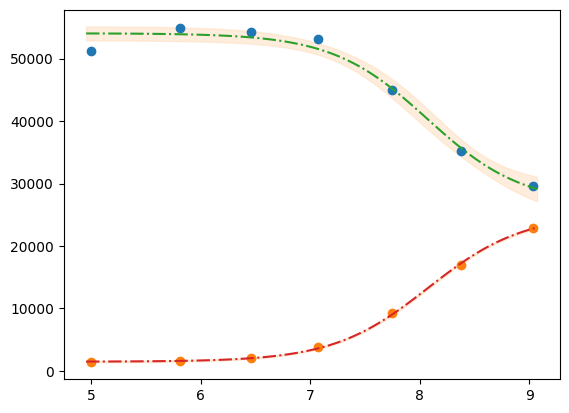

In [34]:
xfit_delta = (df.x.max() - df.x.min()) / 100
xfit = np.arange(df.x.min() - xfit_delta, df.x.max() + xfit_delta, xfit_delta)
dely1 = res1.eval_uncertainty(x=xfit) * 1
dely2 = res2.eval_uncertainty(x=xfit) * 1
best_fit1 = res1.eval(x=xfit)
best_fit2 = res2.eval(x=xfit)
plt.plot(df.x, df.y1, "o")
plt.plot(df.x, df.y2, "o")
plt.plot(xfit, best_fit1, "-.")
plt.plot(xfit, best_fit2, "-.")
plt.fill_between(xfit, best_fit1 - dely1, best_fit1 + dely1, color="#FEDCBA", alpha=0.5)
plt.fill_between(xfit, best_fit2 - dely2, best_fit2 + dely2, color="#FEDCBA", alpha=0.5)

Please mind the difference in the uncertainty between the 2 label
blocks.

In [35]:
def tit_pH2(x, S0_1, S0_2, S1_1, S1_2, K):
    y1 = (S0_1 + S1_1 * 10 ** (K - x)) / (1 + 10 ** (K - x))
    y2 = (S0_2 + S1_2 * 10 ** (K - x)) / (1 + 10 ** (K - x))
    # return y1, y2
    return np.r_[y1, y2]


tit_model = lmfit.Model(tit_pH2)
tit_model.set_param_hint("K", value=7.0, min=2.0, max=12.0)
tit_model.set_param_hint("S0_1", value=df.y1[0], min=0.0)
tit_model.set_param_hint("S0_2", value=df.y2[0], min=0.0)
tit_model.set_param_hint("S1_1", value=df.y1.iloc[-1], min=0.0)
tit_model.set_param_hint("S1_2", value=df.y2.iloc[-1], min=0.0)
pars = tit_model.make_params()
# res = tit_model.fit([df.y1, df.y2], pars, x=df.x)
res = tit_model.fit(np.r_[df.y1, df.y2], pars, x=df.x)
print(res.fit_report())

[[Model]]
    Model(tit_pH2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 14
    # variables        = 5
    chi-square         = 12471473.3
    reduced chi-square = 1385719.25
    Akaike info crit   = 201.798560
    Bayesian info crit = 204.993846
    R-squared          = 0.99794717
[[Variables]]
    S0_1:  26601.3458 +/- 1425.69913 (5.36%) (init = 29657)
    S0_2:  25084.4189 +/- 1337.07982 (5.33%) (init = 22885)
    S1_1:  54034.5806 +/- 627.642479 (1.16%) (init = 51205)
    S1_2:  1473.57871 +/- 616.944649 (41.87%) (init = 1358)
    K:     8.07255029 +/- 0.07600777 (0.94%) (init = 7)
[[Correlations]] (unreported correlations are < 0.100)
    C(S0_1, K)    = -0.6816
    C(S0_2, K)    = +0.6255
    C(S0_1, S0_2) = -0.4264
    C(S1_1, K)    = -0.3611
    C(S1_2, K)    = +0.3161
    C(S0_2, S1_1) = -0.2259
    C(S0_1, S1_2) = -0.2155
    C(S1_1, S1_2) = -0.1141


In [37]:
dely = res.eval_uncertainty(x=xfit)
# res.plot() # this return error because of the global fit

    99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 SA:2338.404511.625450.156052.536642.137512.329321.96
 SB:33406.9634609.8235170.9935544.4435920.0736492.8937756.24
 pK:   6.47   6.60   6.66   6.70   6.74   6.80   6.93


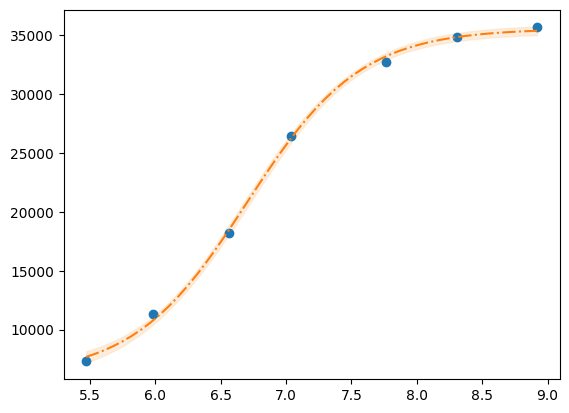

In [38]:
def fit_pH(fp):
    df = pd.read_csv(fp)

    def tit_pH(x, SA, SB, pK):
        return (SB + SA * 10 ** (pK - x)) / (1 + 10 ** (pK - x))

    mod = lmfit.Model(tit_pH)
    pars = mod.make_params(SA=10000, SB=7e3, pK=7)
    result = mod.fit(df.y2, pars, x=df.x)
    return result, df.y2, df.x, mod


# r,y,x,model = fit_pH("/home/dati/ibf/IBF/Database/Random mutag results/Liasan-analyses/2016-05-19/2014-02-20/pH/dat/C12.dat")
r, y, x, model = fit_pH("../../tests/data/H04.dat")
xfit = np.linspace(x.min(), x.max(), 50)
dely = r.eval_uncertainty(x=xfit) * 1
best_fit = r.eval(x=xfit)
plt.plot(x, y, "o")
plt.plot(xfit, best_fit, "-.")
plt.fill_between(xfit, best_fit - dely, best_fit + dely, color="#FEDCBA", alpha=0.5)
r.conf_interval(sigmas=[2])
print(r.ci_report(with_offset=False, ndigits=2))

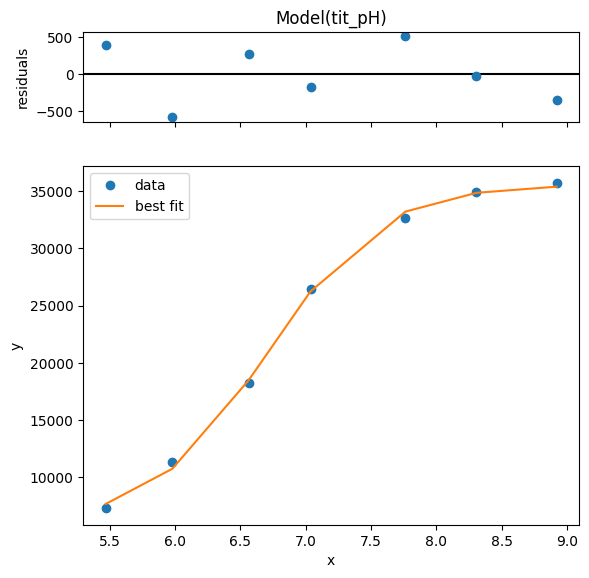

In [39]:
g = r.plot()

In [40]:
print(r.ci_report())

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 SA:-3714.13150-1540.91238-602.378536052.53269+589.59734+1459.78928+3269.42485
 SB:-2137.47758-934.62678-373.4502035544.44185+375.62906+948.44608+2211.79840
 pK:  -0.23398  -0.10021  -0.03976   6.70123  +0.03971  +0.09989  +0.23227


In [41]:
emcee_kws = dict(steps=2000, burn=500, thin=2, is_weighted=False, progress=False)
emcee_params = r.params.copy()
emcee_params.add("__lnsigma", value=np.log(0.1), min=np.log(0.001), max=np.log(2000.0))
result_emcee = model.fit(
    data=y,
    x=x,
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

lmfit.report_fit(result_emcee)

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [38.76703001 43.23947376 36.15180036 63.18673648]
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 200000
    # data points      = 7
    # variables        = 4
    chi-square         = 3.35011030
    reduced chi-square = 1.11670343
    Akaike info crit   = 2.84158186
    Bayesian info crit = 2.62522245
    R-squared          = 1.00000000
[[Variables]]
    SA:         6036.53720 +/- 600.868616 (9.95%) (init = 6052.533)
    SB:         35530.6288 +/- 366.638133 (1.03%) (init = 35544.44)
    pK:         6.69970123 +/- 0.03938973 (0.59%) (init = 6.701226)
    __lnsigma:  6.29985961 +/- 0.37401749 (5.94%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(SA, pK) = +0.6985
    C(SB, pK) = +0.5289
    C(SA, SB) = +0.1840


<Axes: title={'center': 'Model(tit_pH)'}, xlabel='x', ylabel='y'>

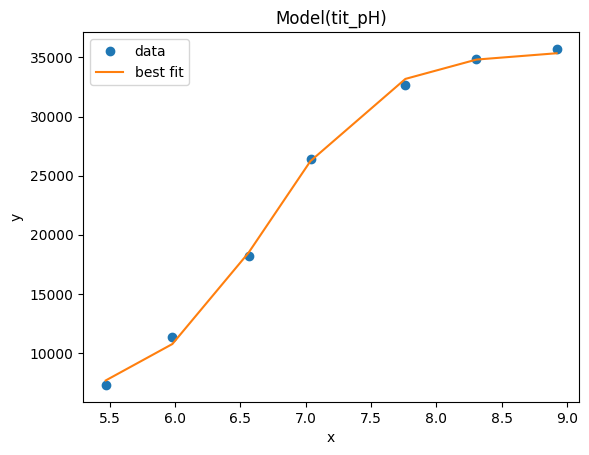

In [42]:
result_emcee.plot_fit()

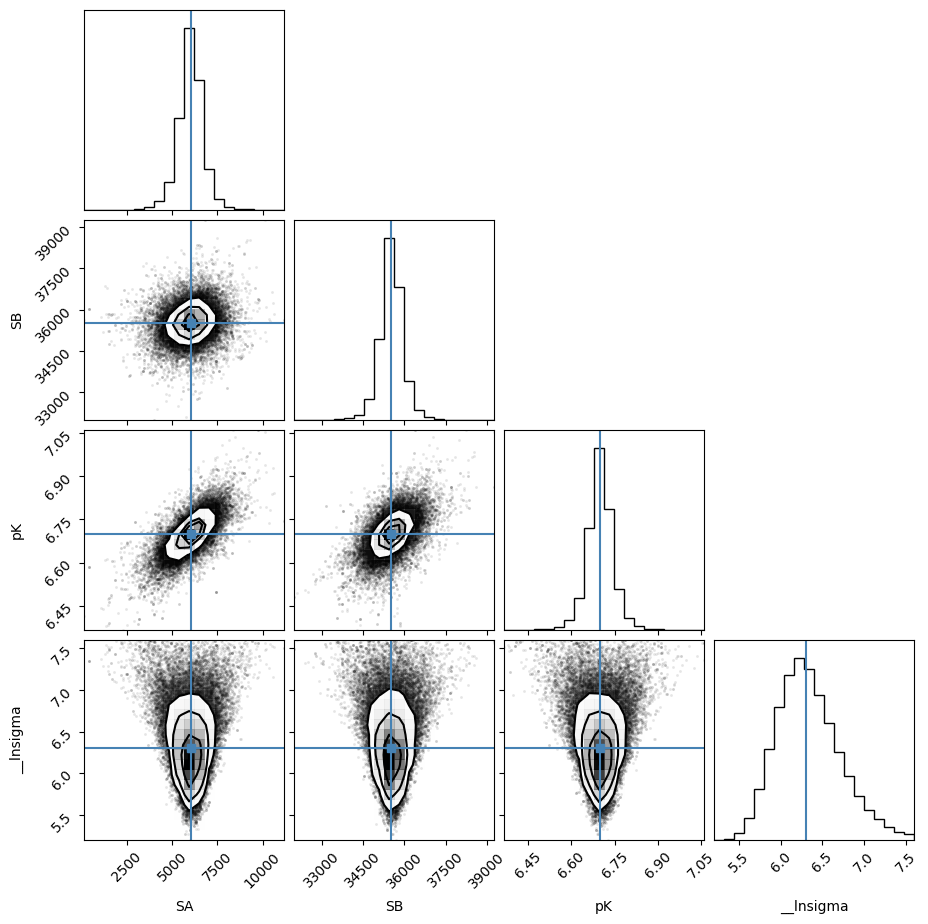

In [43]:
emcee_corner = corner.corner(
    result_emcee.flatchain,
    labels=result_emcee.var_names,
    truths=list(result_emcee.params.valuesdict().values()),
)

In [44]:
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum Likelihood Estimation (MLE):")
print("----------------------------------")
for ix, param in enumerate(emcee_params):
    print(f"{param}: {mle_soln[ix]:.3f}")

quantiles = np.percentile(result_emcee.flatchain["pK"], [2.28, 15.9, 50, 84.2, 97.7])
print(f"\n\n1 sigma spread = {0.5 * (quantiles[3] - quantiles[1]):.3f}")
print(f"2 sigma spread = {0.5 * (quantiles[4] - quantiles[0]):.3f}")


Maximum Likelihood Estimation (MLE):
----------------------------------
SA: 6013.072
SB: 35555.316
pK: 6.700
__lnsigma: 5.916


1 sigma spread = 0.039
2 sigma spread = 0.097


## Example 2P Cl–ratio

### using lmfit.model

    99.73% 95.45% 68.27% _BEST_ 68.27% 95.45% 99.73%
 R0:   0.49   0.58   0.60   0.61   0.62   0.64   0.73
 R1:  -0.30  -0.01   0.03   0.04   0.06   0.09   0.20
 Kd:   2.95  10.09  12.51  13.66  14.91  18.49  59.97


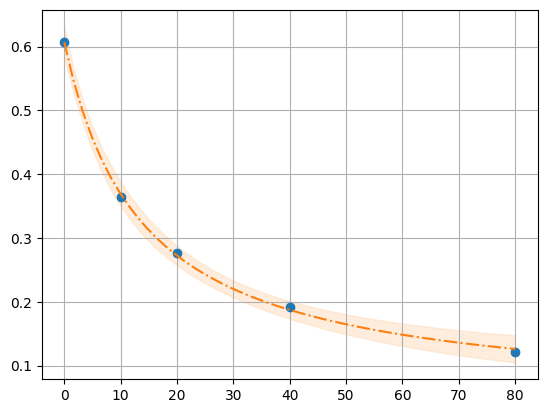

In [45]:
def fit_Rcl(fp):
    df = pd.read_table(fp)

    def R_Cl(cl, R0, R1, Kd):
        return (R1 * cl + R0 * Kd) / (Kd + cl)

    mod = lmfit.Model(R_Cl)
    pars = mod.make_params(R0=0.8, R1=0.05, Kd=10)
    result = mod.fit(df.R, pars, cl=df.cl)
    return result, df.R, df.cl, mod


r, y, x, model = fit_Rcl("../../tests/data/ratio2P.txt")
xfit = np.linspace(x.min(), x.max(), 50)
dely = r.eval_uncertainty(cl=xfit) * 3
best_fit = r.eval(cl=xfit)
plt.plot(x, y, "o")
plt.grid()
plt.plot(xfit, best_fit, "-.")
plt.fill_between(xfit, best_fit - dely, best_fit + dely, color="#FEDCBA", alpha=0.5)
r.conf_interval(sigmas=[2])
print(r.ci_report(with_offset=False, ndigits=2))

In [46]:
emcee_kws = dict(steps=3000, burn=300, thin=2, is_weighted=False, progress=False)
emcee_params = r.params.copy()
emcee_params.add(
    "__lnsigma", value=np.log(0.1), min=np.log(0.000001), max=np.log(2000.0)
)
result_emcee = model.fit(
    data=y,
    cl=x,
    params=emcee_params,
    method="emcee",
    nan_policy="omit",
    fit_kws=emcee_kws,
)

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [54.80962546 64.28863031 67.43800359 85.59541751]


In [47]:
lmfit.report_fit(result_emcee)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 300000
    # data points      = 5
    # variables        = 4
    chi-square         = 1.32163980
    reduced chi-square = 1.32163980
    Akaike info crit   = 1.34717662
    Bayesian info crit = -0.21507173
    R-squared          = -8.29977792
[[Variables]]
    R0:         0.60638388 +/- 0.00870978 (1.44%) (init = 0.6071065)
    R1:         0.04247446 +/- 0.01485099 (34.96%) (init = 0.04390399)
    Kd:         13.8300169 +/- 1.31719846 (9.52%) (init = 13.66125)
    __lnsigma: -4.86201014 +/- 0.62164588 (12.79%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(R0, Kd)        = -0.7362
    C(R1, Kd)        = -0.6577
    C(Kd, __lnsigma) = +0.4008
    C(R1, __lnsigma) = -0.3933
    C(R0, R1)        = +0.3699
    C(R0, __lnsigma) = -0.2982


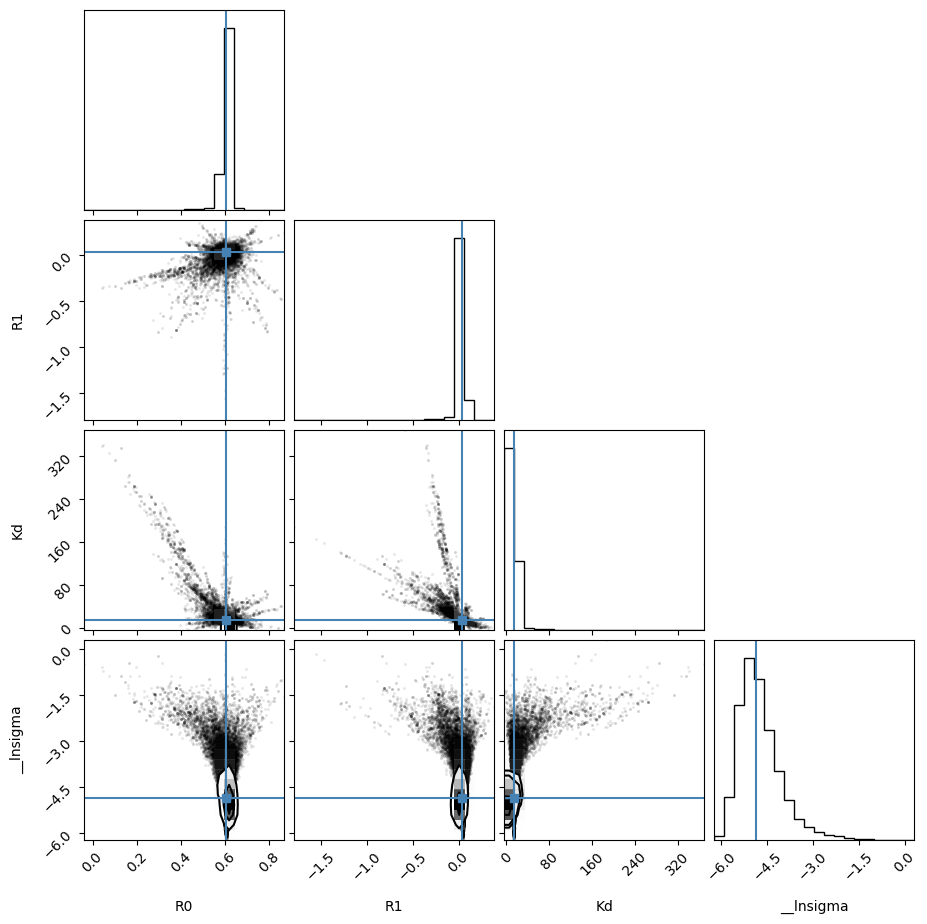

In [48]:
emcee_corner = corner.corner(
    result_emcee.flatchain,
    labels=result_emcee.var_names,
    truths=list(result_emcee.params.valuesdict().values()),
)

In [49]:
highest_prob = np.argmax(result_emcee.lnprob)
hp_loc = np.unravel_index(highest_prob, result_emcee.lnprob.shape)
mle_soln = result_emcee.chain[hp_loc]
print("\nMaximum Likelihood Estimation (MLE):")
print("----------------------------------")
for ix, param in enumerate(emcee_params):
    print(f"{param}: {mle_soln[ix]:.3f}")

quantiles = np.percentile(result_emcee.flatchain["Kd"], [2.28, 15.9, 50, 84.2, 97.7])
print(f"\n\n1 sigma spread = {0.5 * (quantiles[3] - quantiles[1]):.3f}")
print(f"2 sigma spread = {0.5 * (quantiles[4] - quantiles[0]):.3f}")


Maximum Likelihood Estimation (MLE):
----------------------------------
R0: 0.607
R1: 0.043
Kd: 13.724
__lnsigma: -5.535


1 sigma spread = 1.320
2 sigma spread = 6.950
